In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances
from torchvision.utils import make_grid


In [2]:
# Mapear las 100 clases a 20 superclases
superclass_map = {
    0: 4, 1: 1, 2: 14, 3: 8, 4: 0, 5: 6, 6: 7, 7: 7, 8: 18, 9: 3, 10: 3,
    11: 14, 12: 9, 13: 18, 14: 7, 15: 11, 16: 3, 17: 9, 18: 7, 19: 11, 20: 6,
    21: 11, 22: 5, 23: 10, 24: 7, 25: 6, 26: 13, 27: 15, 28: 3, 29: 15, 30: 0,
    31: 11, 32: 1, 33: 10, 34: 12, 35: 14, 36: 16, 37: 9, 38: 11, 39: 5, 40: 5,
    41: 19, 42: 8, 43: 8, 44: 15, 45: 13, 46: 14, 47: 17, 48: 18, 49: 10, 50: 16,
    51: 4, 52: 17, 53: 4, 54: 2, 55: 0, 56: 17, 57: 4, 58: 18, 59: 17, 60: 10,
    61: 3, 62: 2, 63: 12, 64: 12, 65: 16, 66: 12, 67: 1, 68: 9, 69: 19, 70: 2,
    71: 10, 72: 15, 73: 5, 74: 19, 75: 2, 76: 19, 77: 18, 78: 1, 79: 6, 80: 1,
    81: 10, 82: 17, 83: 12, 84: 16, 85: 19, 86: 2, 87: 4, 88: 6, 89: 5, 90: 0,
    91: 17, 92: 8, 93: 14, 94: 13, 95: 19, 96: 18, 97: 0, 98: 16, 99: 13
}

class CIFAR100SuperClass(torchvision.datasets.CIFAR100):
    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        super_target = superclass_map[target]
        return img, super_target

# Transformaciones
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Cargar los datos
train_dataset = CIFAR100SuperClass(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR100SuperClass(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Modelo simple o preentrenado
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')
model.fc = nn.Linear(model.fc.in_features, 20)  # Modificamos para 20 superclases

# Configuración del entrenamiento
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


# Almacenar pérdida y precisión para graficar
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Entrenamiento
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Entrenamiento
num_epochs = 50
for epoch in range(num_epochs):
    # Entrenamiento
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Evaluación
    model.eval()
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss = running_test_loss / len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Files already downloaded and verified
Files already downloaded and verified
Epoch 1/50, Train Loss: 2.1113, Train Accuracy: 35.87%, Test Loss: 1.9268, Test Accuracy: 41.72%
Epoch 2/50, Train Loss: 1.7096, Train Accuracy: 47.51%, Test Loss: 1.8544, Test Accuracy: 45.66%
Epoch 3/50, Train Loss: 1.5488, Train Accuracy: 52.16%, Test Loss: 1.5665, Test Accuracy: 51.60%
Epoch 4/50, Train Loss: 1.4315, Train Accuracy: 55.71%, Test Loss: 1.4726, Test Accuracy: 54.38%
Epoch 5/50, Train Loss: 1.3574, Train Accuracy: 57.73%, Test Loss: 1.4507, Test Accuracy: 55.73%
Epoch 6/50, Train Loss: 1.2890, Train Accuracy: 60.10%, Test Loss: 1.3771, Test Accuracy: 57.65%
Epoch 7/50, Train Loss: 1.2397, Train Accuracy: 61.24%, Test Loss: 1.3977, Test Accuracy: 57.08%
Epoch 8/50, Train Loss: 1.1851, Train Accuracy: 62.72%, Test Loss: 1.3362, Test Accuracy: 58.82%
Epoch 9/50, Train Loss: 1.1460, Train Accuracy: 63.83%, Test Loss: 1.3810, Test Accuracy: 58.92%
Epoch 10/50, Train Loss: 1.1000, Train Accuracy: 65

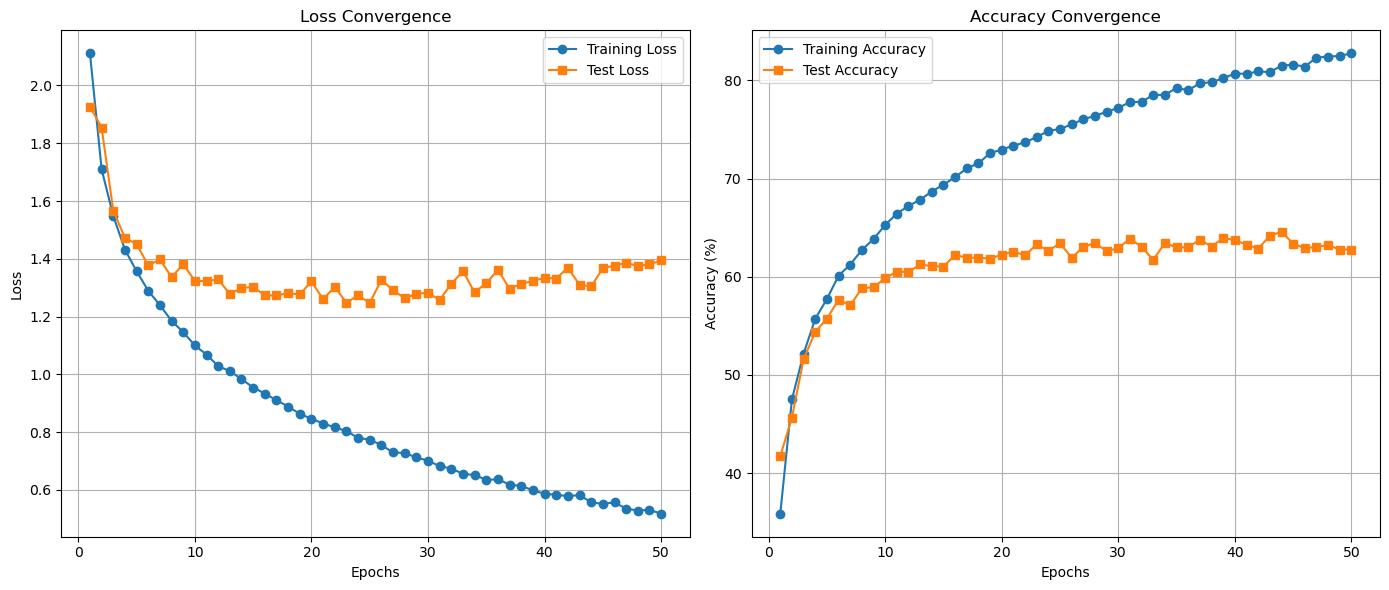

In [3]:
# Graficar pérdidas y precisiones
plt.figure(figsize=(14, 6))

# Pérdidas
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Convergence')
plt.legend()
plt.grid(True)

# Precisión
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Convergence')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

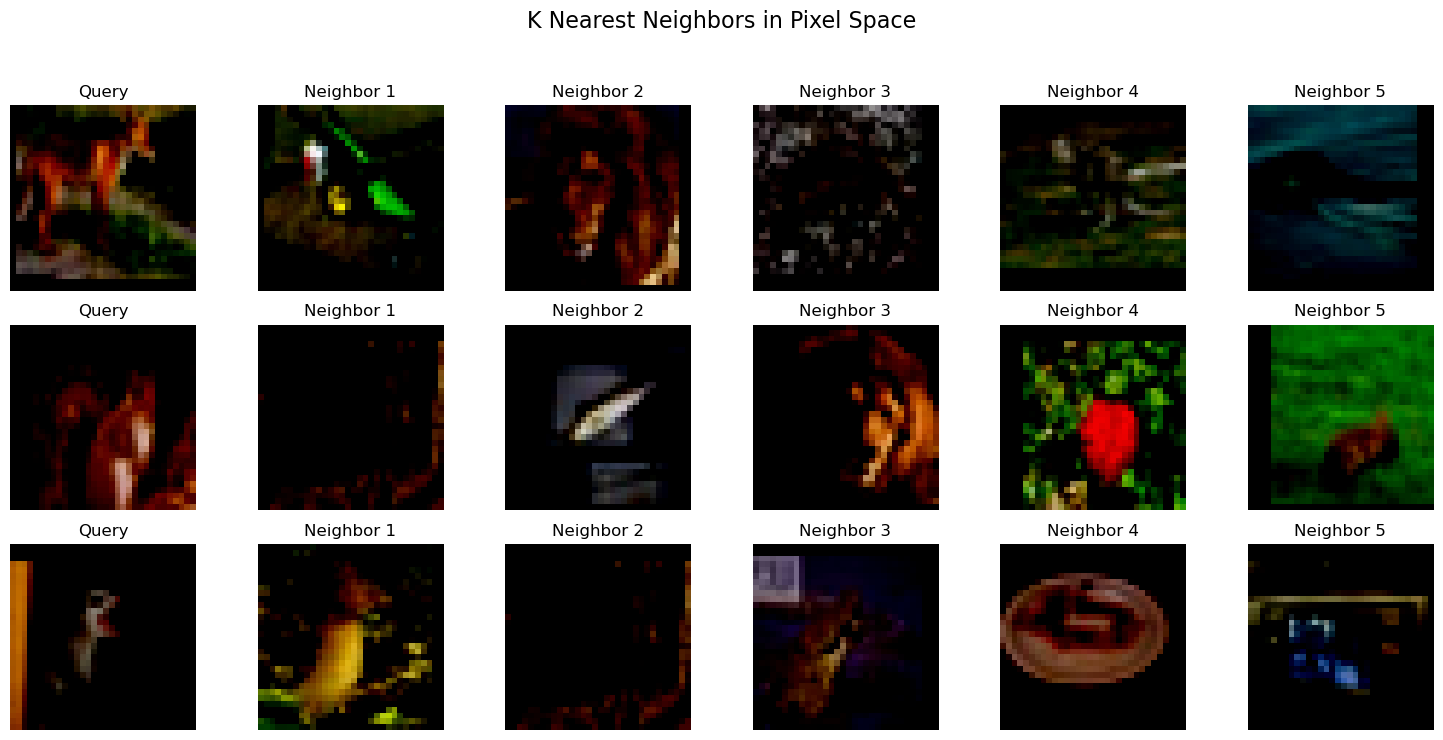

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

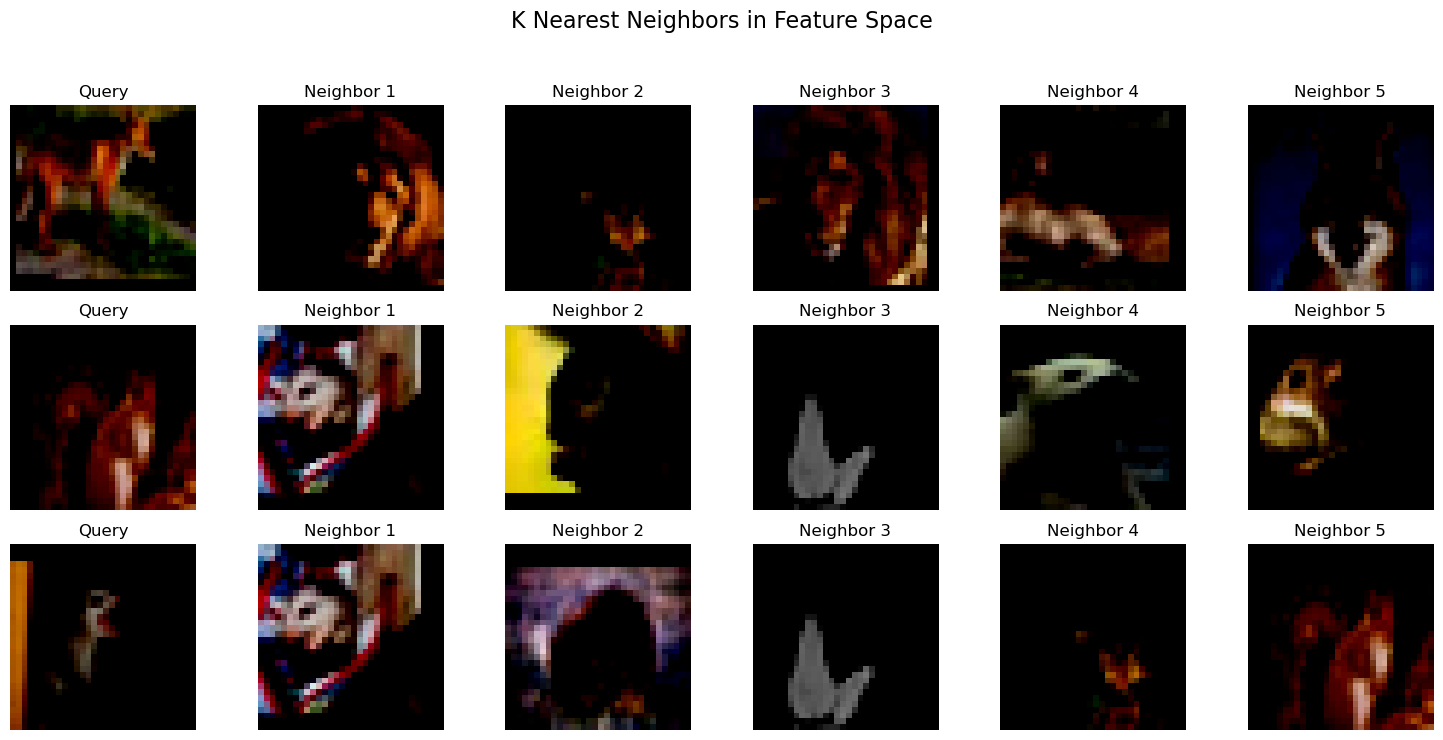

In [47]:
def plot_knn_together(images, knn_indices, title, k=5, num_examples=3):
    """
    Visualiza k vecinos más cercanos para múltiples ejemplos en un solo plot.
    """
    fig, axes = plt.subplots(num_examples, k + 1, figsize=(15, 2.5 * num_examples))
    fig.suptitle(title, fontsize=16)
    
    for example_idx in range(num_examples):
        query_idx = knn_indices[example_idx][0]
        neighbors = knn_indices[example_idx][1:]
        
        # Graficar la consulta
        axes[example_idx, 0].imshow(np.transpose(images[query_idx].cpu().numpy(), (1, 2, 0)))
        axes[example_idx, 0].set_title("Query", fontsize=12)
        axes[example_idx, 0].axis("off")
        
        # Graficar los vecinos
        for i, neighbor_idx in enumerate(neighbors):
            axes[example_idx, i + 1].imshow(np.transpose(images[neighbor_idx].cpu().numpy(), (1, 2, 0)))
            axes[example_idx, i + 1].set_title(f"Neighbor {i + 1}", fontsize=12)
            axes[example_idx, i + 1].axis("off")

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Configurar subconjunto para k vecinos
sample_indices = np.random.choice(len(train_dataset), size=100, replace=False)
sample_loader = DataLoader(
    torch.utils.data.Subset(train_dataset, sample_indices),
    batch_size=len(sample_indices),
    shuffle=False,
)

# Obtener imágenes y etiquetas del subconjunto
images, labels = next(iter(sample_loader))
images, labels = images.to(device), labels.to(device)

# Extraer características del modelo entrenado
model.eval()
with torch.no_grad():
    features = model(images)

# Encontrar k vecinos en ambos espacios
k=5
images_np = images.cpu().numpy()
features_np = features.cpu().numpy()
knn_pixels = np.argsort(euclidean_distances(images_np.reshape(images_np.shape[0], -1)), axis=1)[:, :k+1]
knn_features = np.argsort(euclidean_distances(features_np), axis=1)[:, :k+1]

# Visualizar los resultados
plot_knn_together(
    images,
    knn_pixels,
    title="K Nearest Neighbors in Pixel Space",
    k=5,
    num_examples=3
)

plot_knn_together(
    images,
    knn_features,
    title="K Nearest Neighbors in Feature Space",
    k=5,
    num_examples=3
)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


No examples found for 'flowers', using 'sea' as replacement.


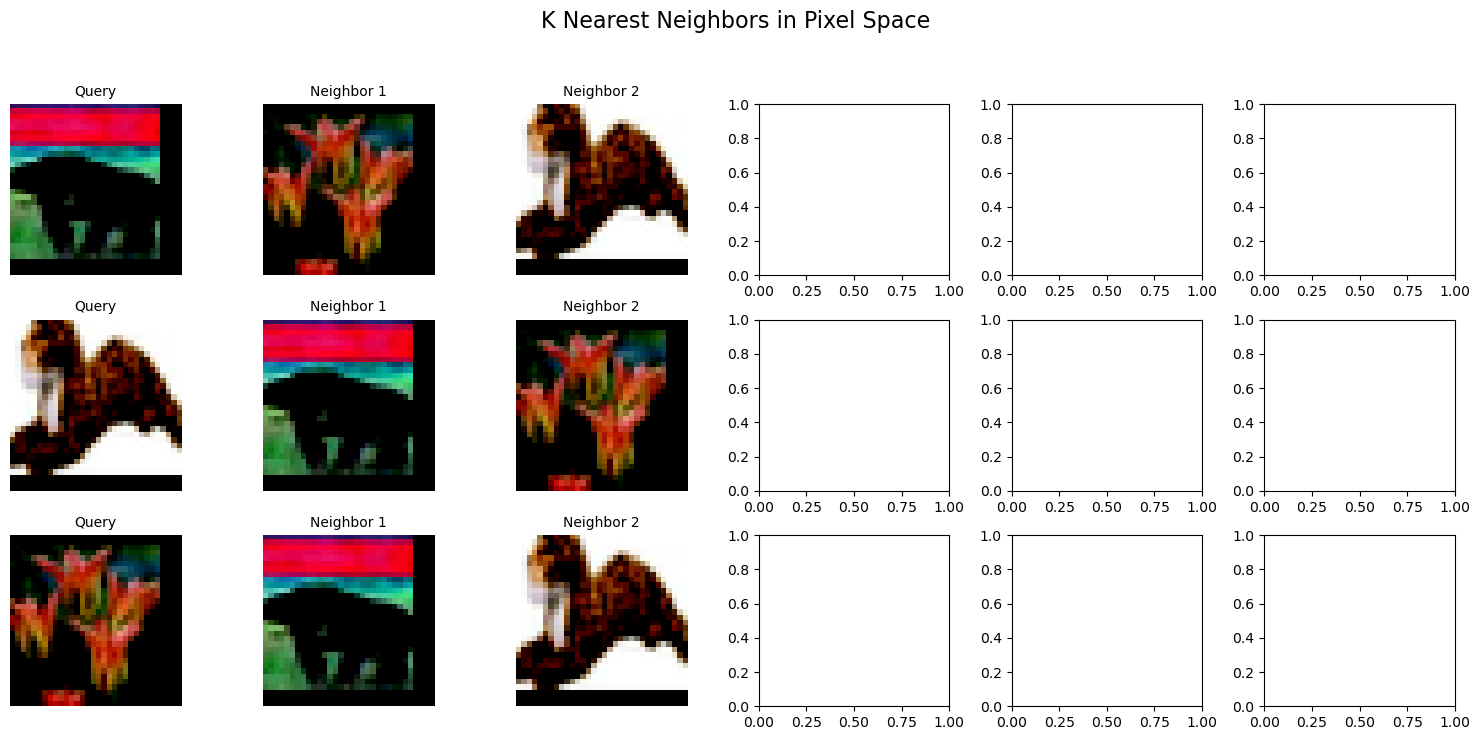

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


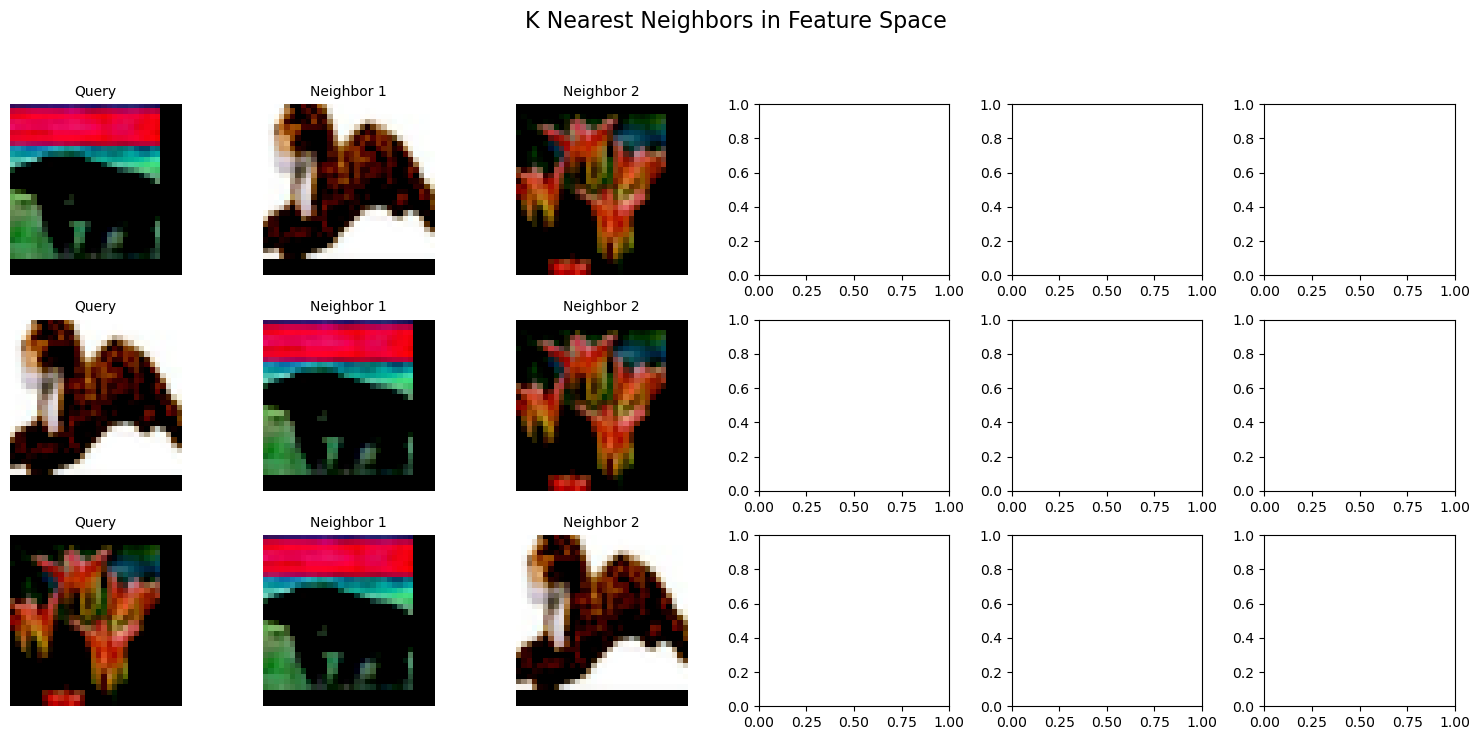

In [30]:
# Superclases específicas
target_superclasses = {
    "people": 14,  # Personas
    "flowers": 16,  # Flores
    "sea": 18  # Animales marinos
}

# Función para filtrar índices por superclase con validación
def filter_indices_by_superclass(dataset, target_superclass):
    indices = []
    for idx, (_, label) in enumerate(dataset):
        if superclass_map[label] == target_superclass:
            indices.append(idx)
    return indices

# Obtener índices para las superclases seleccionadas
people_indices = filter_indices_by_superclass(train_dataset, target_superclasses["people"])
flowers_indices = filter_indices_by_superclass(train_dataset, target_superclasses["flowers"])
sea_indices = filter_indices_by_superclass(train_dataset, target_superclasses["sea"])

# Validar que haya ejemplos y manejar casos vacíos
if not people_indices:
    print("No examples found for 'people', using 'flowers' as replacement.")
    people_indices = flowers_indices[:1]
if not flowers_indices:
    print("No examples found for 'flowers', using 'sea' as replacement.")
    flowers_indices = sea_indices[:1]
if not sea_indices:
    print("No examples found for 'sea', using 'people' as replacement.")
    sea_indices = people_indices[:1]

# Seleccionar ejemplos aleatorios
selected_indices = (
    np.random.choice(people_indices, size=1, replace=False).tolist() +
    np.random.choice(flowers_indices, size=1, replace=False).tolist() +
    np.random.choice(sea_indices, size=1, replace=False).tolist()
)

# Crear DataLoader para ejemplos seleccionados
example_loader = DataLoader(
    torch.utils.data.Subset(train_dataset, selected_indices),
    batch_size=len(selected_indices),
    shuffle=False
)

# Obtener imágenes y etiquetas de los ejemplos seleccionados
example_images, example_labels = next(iter(example_loader))
example_images = example_images.to(device)

# Modelo entrenado (modifica según tu modelo)
# model = torchvision.models.resnet18(pretrained=True)
# model.fc = torch.nn.Linear(model.fc.in_features, 20)  # Ajustado para 20 superclases
# model.load_state_dict(torch.load("model.pth"))  # Carga los pesos entrenados
# model = model.to(device)
model.eval()

# Extraer características del modelo entrenado
with torch.no_grad():
    example_features = model(example_images)

# Vecinos más cercanos
example_images_np = example_images.cpu().numpy()
example_features_np = example_features.cpu().numpy()
knn_pixels = np.argsort(euclidean_distances(example_images_np.reshape(example_images_np.shape[0], -1)), axis=1)[:, :6]
knn_features = np.argsort(euclidean_distances(example_features_np), axis=1)[:, :6]

# Función para graficar vecinos
def plot_knn_together_compact(images, knn_indices, title, k=5):
    num_examples = len(knn_indices)
    fig, axes = plt.subplots(num_examples, k + 1, figsize=(15, 2.5 * num_examples))
    fig.suptitle(title, fontsize=16)
    
    for example_idx in range(num_examples):
        query_idx = knn_indices[example_idx][0]
        neighbors = knn_indices[example_idx][1:]
        
        # Graficar la consulta
        axes[example_idx, 0].imshow(np.transpose(images[query_idx].cpu().numpy(), (1, 2, 0)))
        axes[example_idx, 0].set_title("Query", fontsize=10)
        axes[example_idx, 0].axis("off")
        
        # Graficar los vecinos
        for i, neighbor_idx in enumerate(neighbors):
            axes[example_idx, i + 1].imshow(np.transpose(images[neighbor_idx].cpu().numpy(), (1, 2, 0)))
            axes[example_idx, i + 1].set_title(f"Neighbor {i + 1}", fontsize=10)
            axes[example_idx, i + 1].axis("off")
    
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Visualizar vecinos en el espacio de píxeles
plot_knn_together_compact(
    example_images,
    knn_pixels,
    title="K Nearest Neighbors in Pixel Space",
    k=5
)

# Visualizar vecinos en el espacio de características
plot_knn_together_compact(
    example_images,
    knn_features,
    title="K Nearest Neighbors in Feature Space",
    k=5
)

In [65]:
# Mapear las 100 clases a 20 superclases
superclass_map = {
    0: 4, 1: 1, 2: 14, 3: 8, 4: 0, 5: 6, 6: 7, 7: 7, 8: 18, 9: 3, 10: 3,
    11: 14, 12: 9, 13: 18, 14: 7, 15: 11, 16: 3, 17: 9, 18: 7, 19: 11, 20: 6,
    21: 11, 22: 5, 23: 10, 24: 7, 25: 6, 26: 13, 27: 15, 28: 3, 29: 15, 30: 0,
    31: 11, 32: 1, 33: 10, 34: 12, 35: 14, 36: 16, 37: 9, 38: 11, 39: 5, 40: 5,
    41: 19, 42: 8, 43: 8, 44: 15, 45: 13, 46: 14, 47: 17, 48: 18, 49: 10, 50: 16,
    51: 4, 52: 17, 53: 4, 54: 2, 55: 0, 56: 17, 57: 4, 58: 18, 59: 17, 60: 10,
    61: 3, 62: 2, 63: 12, 64: 12, 65: 16, 66: 12, 67: 1, 68: 9, 69: 19, 70: 2,
    71: 10, 72: 15, 73: 5, 74: 19, 75: 2, 76: 19, 77: 18, 78: 1, 79: 6, 80: 1,
    81: 10, 82: 17, 83: 12, 84: 16, 85: 19, 86: 2, 87: 4, 88: 6, 89: 5, 90: 0,
    91: 17, 92: 8, 93: 14, 94: 13, 95: 19, 96: 18, 97: 0, 98: 16, 99: 13
}

class CIFAR100SuperClass(torchvision.datasets.CIFAR100):
    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        super_target = superclass_map[target]
        return img, super_target

# Transformaciones
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010), inplace=True)
])


# Cargar los datos
train_dataset = CIFAR100SuperClass(root='./data', train=True, download=True, transform=transform)
test_dataset = CIFAR100SuperClass(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [66]:
class LeNet5_Optimized(nn.Module):
    def __init__(self):
        super(LeNet5_Optimized, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv_extra = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0)
        self.bn_extra = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 120, kernel_size=5, stride=1, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 20)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        conv1_out = torch.relu(self.bn1(self.conv1(x)))
        pool1_out = self.pool1(conv1_out)

        conv2_out = torch.relu(self.bn2(self.conv2(pool1_out)))
        conv_extra_out = torch.relu(self.bn_extra(self.conv_extra(conv2_out)))
        pool2_out = self.pool2(conv_extra_out)

        conv3_out = torch.relu(self.conv3(pool2_out))
        x_flatten = conv3_out.view(conv3_out.size(0), -1)

        fc1_out = self.dropout(torch.relu(self.fc1(x_flatten)))
        output = torch.softmax(self.fc2(fc1_out), dim=1)

        return output


In [67]:
model = LeNet5_Optimized()

In [68]:
# Almacenar pérdida y precisión para graficar
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Entrenamiento
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Entrenamiento
num_epochs = 50
for epoch in range(num_epochs):
    # Entrenamiento
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Evaluación
    model.eval()
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss = running_test_loss / len(test_loader)
    test_losses.append(test_loss)
    test_accuracy = 100 * correct_test / total_test
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
          f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Epoch 1/50, Train Loss: 2.9958, Train Accuracy: 5.23%, Test Loss: 2.9958, Test Accuracy: 5.33%
Epoch 2/50, Train Loss: 2.9958, Train Accuracy: 5.18%, Test Loss: 2.9958, Test Accuracy: 5.45%
Epoch 3/50, Train Loss: 2.9958, Train Accuracy: 5.14%, Test Loss: 2.9958, Test Accuracy: 5.36%
Epoch 4/50, Train Loss: 2.9958, Train Accuracy: 5.30%, Test Loss: 2.9957, Test Accuracy: 5.43%
Epoch 5/50, Train Loss: 2.9958, Train Accuracy: 5.25%, Test Loss: 2.9958, Test Accuracy: 5.26%
Epoch 6/50, Train Loss: 2.9958, Train Accuracy: 5.32%, Test Loss: 2.9958, Test Accuracy: 5.38%
Epoch 7/50, Train Loss: 2.9958, Train Accuracy: 5.08%, Test Loss: 2.9958, Test Accuracy: 5.22%
Epoch 8/50, Train Loss: 2.9958, Train Accuracy: 5.20%, Test Loss: 2.9958, Test Accuracy: 5.21%
Epoch 9/50, Train Loss: 2.9958, Train Accuracy: 5.17%, Test Loss: 2.9958, Test Accuracy: 5.41%


KeyboardInterrupt: 